# Сборный проект: создание модели оценки риска дтп на определенном маршруте
 Задачи:
 
- Создать модель предсказания ДТП (целевое значение — at_fault (виновник) в таблице parties)

- Для модели выбрать тип виновника — только машина (car).

- Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).

- Для моделирования ограничиться данными за 2012 год — они самые свежие.

- Обязательное условие — учесть фактор возраста автомобиля.

- На основе модели исследовать основные факторы ДТП.

- Понять, помогут ли результаты моделирования и анализ важности факторов ответить на вопросы:
    - Возможно ли создать адекватную системы оценки водительского риска при выдаче авто? 
    - Какие ещё факторы нужно учесть?
    - Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?
    
Краткое описание таблиц:
  - collisions — общая информация о ДТП

  - Имеет уникальный case_id. Эта таблица описывает общую информацию о ДТП. Например, где оно произошло и когда.
  - parties — информация об участниках ДТП
    Имеет неуникальный case_id, который сопоставляется с соответствующим ДТП в таблице collisions. Каждая строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице должно быть две строки с совпадением case_id. Если нужен уникальный идентификатор, это case_id and party_number.
    
    
  - vehicles — информация о пострадавших машинах
    Имеет неуникальные case_id и неуникальные party_number, которые сопоставляются с таблицей collisions и таблицей parties. Если нужен уникальный идентификатор, это case_id and party_number.
    

In [4]:
!pip -q install skorch

In [5]:
!pip -q install torcheval

In [6]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine 
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.init as init
import torch.nn as nn
from torch import tensor
from torch.optim import Adam
from torcheval.metrics.functional import multiclass_f1_score

from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring, EarlyStopping

from sklearn.metrics import make_scorer, f1_score, roc_auc_score, confusion_matrix,fbeta_score,precision_recall_curve,PrecisionRecallDisplay,plot_roc_curve
    
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, RandomizedSearchCV , cross_val_score
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer


from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from catboost import  Pool

from math import ceil

import warnings
warnings.filterwarnings("ignore")

SEED = np.random.RandomState(0)
torch.manual_seed(3826)

## Подключитесь к базе. Загрузите таблицы sql

In [7]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [8]:
engine = create_engine(connection_string) 

## Проведите первичное исследование таблиц

In [10]:
query = '''
SELECT table_name
FROM information_schema.tables
WHERE table_type = 'BASE TABLE'
'''
sample_df=pd.read_sql_query(query, con=engine) 

In [11]:
display(sample_df)

,table_name
0,pg_type
1,pg_foreign_table
2,pg_amop
3,pg_amproc
4,pg_language
...,...
59,pg_inherits
60,collisions
61,case_ids
62,parties


In [12]:
query = '''
SELECT *
FROM collisions
LIMIT 10
'''

sample_df_coll = pd.read_sql_query(query, con=engine) 

In [13]:
sample_df_coll

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00
5,4083097,0109,alameda,0.0,None,1,clear,ramp,small damage,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-18,02:18:00
6,4083092,1942,los angeles,1320.0,south,0,clear,highway,scratch,2,vehicle code violation,unsafe lane change,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,10:30:00
7,4083096,1942,los angeles,200.0,south,0,clear,highway,scratch,3,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,08:55:00
8,4083100,1942,los angeles,2112.0,north,0,cloudy,highway,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,16:20:00
9,4083103,4313,santa clara,0.0,None,1,cloudy,None,scratch,2,vehicle code violation,None,broadside,other motor vehicle,wet,normal,dusk or dawn,functioning,2009-01-02,15:55:00


In [14]:
query = '''
SELECT *
FROM Parties
LIMIT 10
'''

sample_df_part = pd.read_sql_query(query, con=engine) 

In [15]:
sample_df_part

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0
5,43,3899481,2,road bumper,0,NaN,not applicable,not applicable,0.0
6,72,3899505,2,road bumper,0,NaN,not applicable,not applicable,0.0
7,73,3899505,3,road bumper,0,NaN,not applicable,not applicable,0.0
8,76,3899509,1,road bumper,0,NaN,had not been drinking,None,0.0
9,93,3981292,2,road bumper,0,NaN,had not been drinking,None,NaN


In [12]:
query = '''
SELECT *
FROM Vehicles
LIMIT 10
'''

sample_df_veh = pd.read_sql_query(query, con=engine) 

In [13]:
sample_df_veh

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5
5,1175737,5305046,2,sedan,auto,5
6,1175750,5305053,3,sedan,auto,9
7,1175715,5305033,1,sedan,manual,10
8,1175716,5305033,2,sedan,manual,4
9,1175758,5305060,2,sedan,auto,11


<div style="padding: 30px 25px; border: 5px #9966FF solid">
    
### вывод по главе 'Подключекние к базе. Загрузка таблиц sql':
- подключились к бд
- посмотрели на связь таблиц между собой
- посмотрели на данные из таблиц collisions,Parties,Vehicles

##  Проведите статистический анализ факторов ДТП

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:0px;
            border: 5px double;
            border-color:#9966FF;
            background-color: #FFFFCC;
            overflow:hidden;
            font-weight:400"> 
    
### sql

In [14]:
#дтп по годам и месяцам 
query = '''
SELECT EXTRACT(month from collision_date) AS month_date,
       EXTRACT(YEAR FROM collision_date) AS year,
      COUNT(case_id) AS total_collisions
FROM collisions
GROUP BY 1,2
ORDER BY 1,2 desc
'''

count_collions = pd.read_sql_query(query, con=engine)

In [15]:
#кол-во дтп по тяжести в зависимости от состояния дороги
query = '''
SELECT collision_damage,
       road_condition_1 AS road_condition,
       COUNT(collision_damage)  
FROM collisions
WHERE road_condition_1 != 'normal'
GROUP BY 1,2
ORDER BY 1,2 ASC
'''
road_collisions = pd.read_sql_query(query, con=engine)

In [16]:
#кол-во дтп по тяжести в зависимости от покрытия дороги
query = '''
SELECT  collision_damage,
        road_surface,
        COUNT(collision_damage)
FROM collisions
GROUP BY 1,2
ORDER BY 1,2 ASC
'''
road_surface= pd.read_sql_query(query, con=engine)

In [17]:
#основной фактор аварии
query = '''
SELECT primary_collision_factor,
       COUNT(primary_collision_factor) cnt_col_factor
FROM collisions
WHERE primary_collision_factor != 'unknown' 
GROUP BY 1
ORDER BY 2 DESC
'''
collisions_reasons = pd.read_sql_query(query, con=engine)

In [18]:
# нарушение пдд
query = '''
SELECT PCF_VIOLATION_CATEGORY,
       COUNT(PCF_VIOLATION_CATEGORY) cnt_col_factor
FROM collisions
GROUP BY 1
ORDER BY 2 DESC
'''
collisions_category = pd.read_sql_query(query, con=engine)

In [19]:
#тяжесть аварии в зависимости от состояния водителя(лекарства)
query = '''
SELECT  c.collision_damage,
        COUNT(c.collision_damage) cnt,
        p.PARTY_DRUG_PHYSICAL
FROM collisions as c
LEFT JOIN Parties as p ON c.case_id=p.case_id
WHERE (party_drug_physical != 'not applicable' AND party_drug_physical != 'G')
GROUP BY 1,3
ORDER BY 3 ASC
'''
party_drug_physical = pd.read_sql_query(query, con=engine)

In [20]:
party_drug_physical

,collision_damage,cnt,party_drug_physical
0,fatal,62,impairment - physical
1,middle damage,738,impairment - physical
2,scratch,1064,impairment - physical
3,severe damage,163,impairment - physical
4,small damage,2161,impairment - physical
5,fatal,133,sleepy/fatigued
6,middle damage,2243,sleepy/fatigued
7,scratch,2859,sleepy/fatigued
8,severe damage,379,sleepy/fatigued
9,small damage,7027,sleepy/fatigued


In [21]:
#тяжесть аварии в зависимости от состояния водителя(алкоголь)
query = '''
SELECT  c.collision_damage,
        COUNT(c.collision_damage) cnt,
        p.PARTY_SOBRIETY
FROM collisions as c
LEFT JOIN Parties as p ON c.case_id=p.case_id
WHERE( PARTY_SOBRIETY != 'not applicable' and PARTY_SOBRIETY != 'G')

GROUP BY 1,3
ORDER BY 3 DESC
'''
party_sobriety = pd.read_sql_query(query, con=engine)

In [22]:
party_sobriety

,collision_damage,cnt,party_sobriety
0,fatal,1871,impairment unknown
1,middle damage,14281,impairment unknown
2,scratch,34345,impairment unknown
3,severe damage,4384,impairment unknown
4,small damage,178020,impairment unknown
5,fatal,12263,had not been drinking
6,middle damage,248863,had not been drinking
7,scratch,638601,had not been drinking
8,severe damage,39527,had not been drinking
9,small damage,1185473,had not been drinking


<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:0px;
            border: 5px double;
            border-color:#9966FF;
            background-color: #FFFFCC;
            overflow:hidden;
            font-weight:400"> 
    
### графики

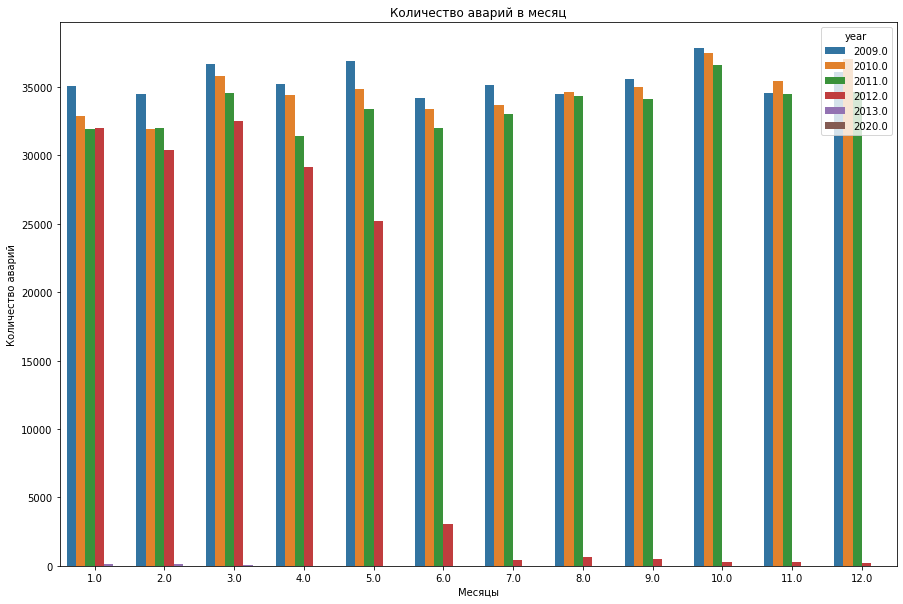

In [23]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.barplot(data = count_collions, x='month_date', y='total_collisions', hue='year')

plt.title('Количество аварий в месяц')
plt.xlabel('Месяцы')
plt.ylabel('Количество аварий')
plt.show()

<div style="padding: 30px 25px; border: 2px #9966FF solid">
вывод: график показывает, что с каждым годом количество аварий снижается, также видно, что аварии не сильно зависят от месяца однако из иобщего графика выделяется октябрь.Естть аномалии в 2012 году, с 1 по 6 месяц количество аварий заметно снижалось(кроме марта, в этом месяце количество аварий за 2012 год было таким же как и в январе) по сравнению с остальными годами, а с 7 по 12 месяцы количество аварий не сильно менялось 

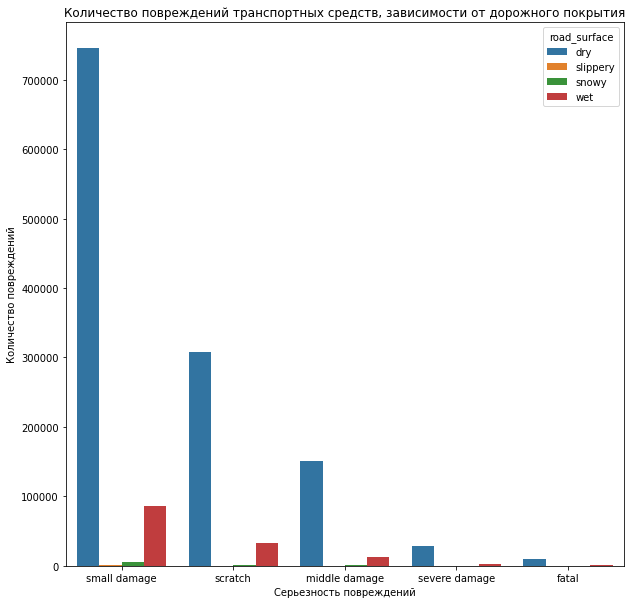

In [24]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.barplot(data = road_surface, x ='collision_damage', y ='count',hue="road_surface",
            order=['small damage','scratch',  'middle damage', 'severe damage', 'fatal'])

plt.title('Количество повреждений транспортных средств, зависимости от дорожного покрытия')
plt.xlabel('Серьезность повреждений')
plt.ylabel('Количество повреждений')
plt.show()

<div style="padding: 30px 25px; border: 2px #9966FF solid">
вывод: большенство повреждений происходят на сухой дороге могу предположить, что это связано с ошибочной увереностью водителей о том что сухая дорога абсолютно безопасна и они всехда успеют вовремя затормозить или обьехать препятствие.

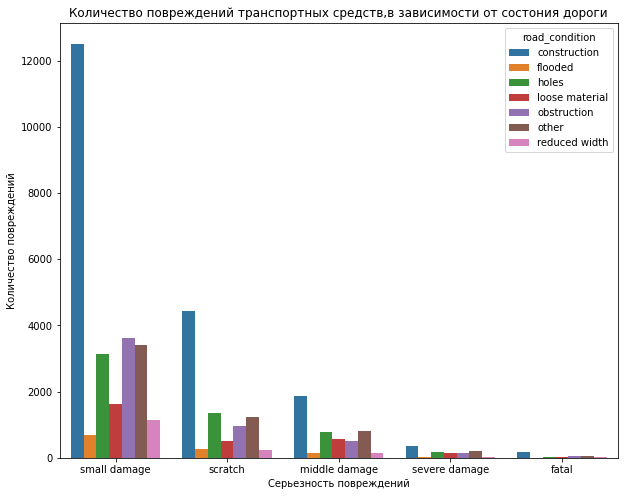

In [25]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.barplot(data = road_collisions, x ='collision_damage', y ='count',hue="road_condition",
            order=['small damage','scratch',  'middle damage', 'severe damage', 'fatal'])

plt.title('Количество повреждений транспортных средств,в зависимости от состония дороги')
plt.xlabel('Серьезность повреждений')
plt.ylabel('Количество повреждений')
plt.show()

<div style="padding: 30px 25px; border: 2px #9966FF solid">
вывод: значительная часть дтп происходит из-за дорожных работ, скорее всего строители не помечают должным образом место проведения работ, либо водители хотят проехать подобное место по быстрее в следствии чего нарушают пдд.

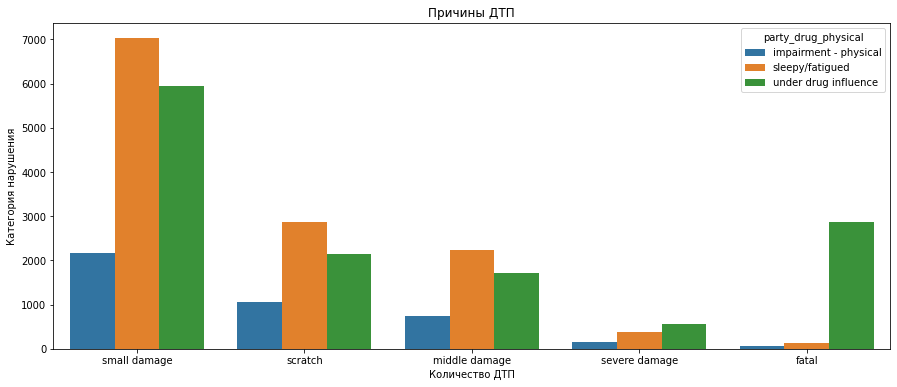

In [26]:
fig, ax = plt.subplots(figsize=(15, 6))

sns.barplot(x='collision_damage', y='cnt', hue= 'party_drug_physical',data=party_drug_physical,
            order=['small damage','scratch',  'middle damage', 'severe damage', 'fatal'])

plt.title('Причины ДТП')
plt.xlabel('Количество ДТП')
plt.ylabel('Категория нарушения')
plt.show()

<div style="padding: 30px 25px; border: 2px #9966FF solid">
вывод: четко видно звависимость усталости водителя и кол-во аварий

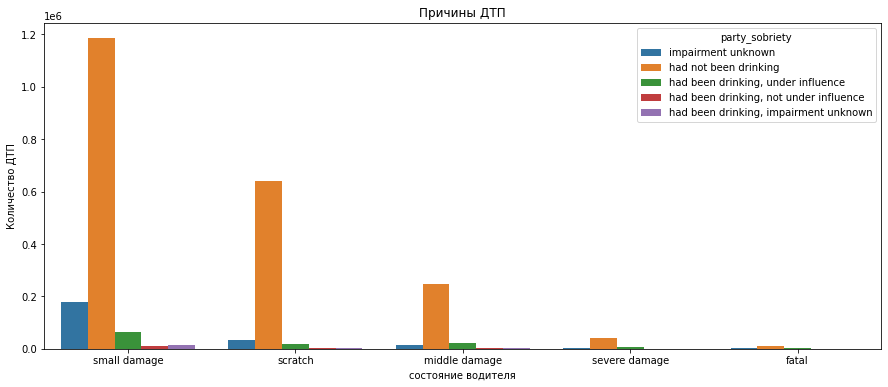

In [27]:
fig, ax = plt.subplots(figsize=(15, 6))

sns.barplot(x='collision_damage', y='cnt',hue='party_sobriety', data=party_sobriety,
           order=['small damage','scratch',  'middle damage', 'severe damage', 'fatal'])

plt.title('Причины ДТП')
plt.xlabel('состояние водителя')
plt.ylabel('Количество ДТП')
plt.show()

<div style="padding: 30px 25px; border: 2px #9966FF solid">
вывод: четко видно звависимость трезвости водителя и кол-во аварий, в основном аварии происходят когда водитель не пил

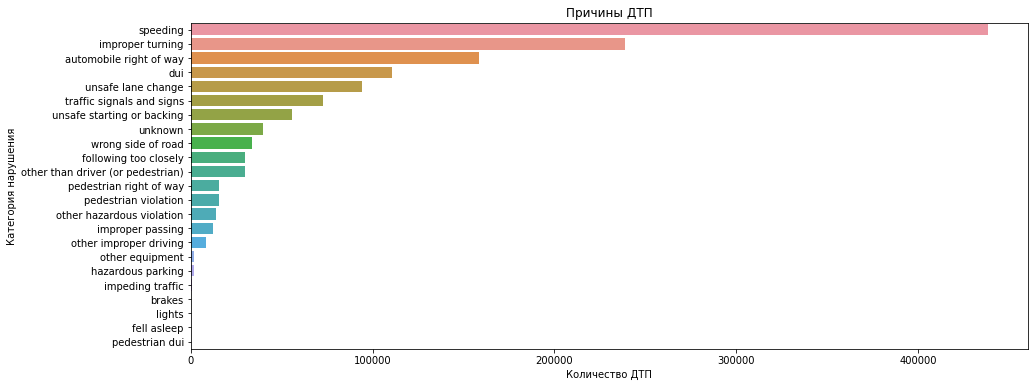

In [28]:
ig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(x='cnt_col_factor', y='pcf_violation_category',data=collisions_category)
plt.title('Причины ДТП')
plt.xlabel('Количество ДТП')
plt.ylabel('Категория нарушения')
plt.show()

<div style="padding: 30px 25px; border: 2px #9966FF solid">
вывод: основной причитной дтп является не соблюдение скоростного режима, это нарушение пдд встречается почти в 2 раза чаще чем вторая самая частая причина аварий поворот в неустановленном месте.

<div style="padding: 30px 25px; border: 5px #9966FF solid">
    
### вывод по главе 'статистический анализ факторов ДТП':
    
выяснили, что количество дтп не зависит от месяца и времни года, и с каждым годом уменьшается.
    
основыми причинами дтп являются:
- сухая дорога на которой водители не соблюдают скоростной режим
- дорогжные работы
- поворот в не разрешенном для этого месте
-усталость водителя

## Создайте модель для оценки водительского риска

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:0px;
            border: 5px double;
            border-color:#9966FF;
            background-color: #FFFFCC;
            overflow:hidden;
            font-weight:400"> 

### Подготовка данных

In [29]:
def data_analis (df):
    i=df.info()
    h=df.head()
    ds=df.describe()
    dp=df.duplicated().sum()
    isna = df.isna().sum()
    return print(i),display(h), display(ds), print('дубликаты:',dp), print('пропуски:', isna,sep=' ')

Для создания модели нам понадобятся следующие признаки:

таблица collisions:
intersection (является ли место происшествия перекрестком)
weather_1 (погода)
road_surface (состояние дороги)
lighting (освещение)
location_type (тип дороги)
road_condition_1 (состояние дорожного покрытия)
таблица parties:
at_fault (виновность участника) - целевой признак
party_sobriety (трезвость участника
party_drug_physical (состояние участника: физическое или с учётом принятых лекарств)
cellphone_in_use (наличие телефона в автомобиле - возможности разговаривать по громкой связи)
таблица vehicles:
vehicle_type (тип кузова)
vehicle_transmission (тип КПП)
vehicle_age (возраст автомобиля)
Все эти признаки важны, так как отражают и объективные причины ДТП (состояние дороги и транспортного средства), и субъективные - состояние участника ДТП.

In [30]:
query = '''
with 
c AS (SELECT DISTINCT case_id,
             intersection,
             weather_1,
             road_surface,
             lighting,
             location_type,
             road_condition_1,
             control_device
      FROM collisions
      WHERE EXTRACT(YEAR FROM collision_date) = 2012
            AND collision_damage != 'scratch'),
p AS (SELECT  DISTINCT case_id,
             at_fault,
             party_sobriety,
             party_drug_physical,
             cellphone_in_use
      FROM parties
      WHERE party_type = 'car'),
      
v AS (SELECT  DISTINCT case_id,
             vehicle_type,
             vehicle_transmission,
             vehicle_age
       FROM vehicles),
       
c_i as (SELECT DISTINCT case_id
        FROM case_ids)
        
SELECT  p.at_fault,
        p.party_sobriety,
        p.party_drug_physical,
        p.cellphone_in_use,
        c.intersection,
        c.weather_1,
        c.road_surface,
        c.lighting,
        c.location_type,
        c.road_condition_1,
        c.control_device,
        v.vehicle_type,           
        v.vehicle_transmission,
        v.vehicle_age
FROM c_i
JOIN c on c_i.case_id = c.case_id
JOIN p on c_i.case_id = p.case_id
JOIN v on c_i.case_id = v.case_id
'''
df = pd.read_sql_query(query, con=engine)

In [31]:
data_analis(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103445 entries, 0 to 103444
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   at_fault              103445 non-null  int64  
 1   party_sobriety        101841 non-null  object 
 2   party_drug_physical   8525 non-null    object 
 3   cellphone_in_use      93431 non-null   float64
 4   intersection          103108 non-null  float64
 5   weather_1             103135 non-null  object 
 6   road_surface          102812 non-null  object 
 7   lighting              103161 non-null  object 
 8   location_type         46284 non-null   object 
 9   road_condition_1      102983 non-null  object 
 10  control_device        103044 non-null  object 
 11  vehicle_type          103445 non-null  object 
 12  vehicle_transmission  101787 non-null  object 
 13  vehicle_age           100457 non-null  float64
dtypes: float64(3), int64(1), object(10)
memory usage: 11

,at_fault,party_sobriety,party_drug_physical,cellphone_in_use,intersection,weather_1,road_surface,lighting,location_type,road_condition_1,control_device,vehicle_type,vehicle_transmission,vehicle_age
0,1,had not been drinking,None,0.0,0.0,clear,dry,dark with no street lights,None,normal,none,sedan,auto,0.0
1,1,had not been drinking,None,0.0,0.0,clear,dry,daylight,highway,normal,none,sedan,manual,11.0
2,0,impairment unknown,G,NaN,0.0,clear,dry,dark with street lights,None,normal,functioning,coupe,manual,2.0
3,0,impairment unknown,G,NaN,0.0,clear,dry,dark with street lights,None,normal,functioning,coupe,auto,7.0
4,0,had not been drinking,None,0.0,0.0,cloudy,dry,daylight,None,holes,none,coupe,auto,4.0


,at_fault,cellphone_in_use,intersection,vehicle_age
count,103445.000000,93431.000000,103108.000000,100457.000000
mean,0.530775,0.021278,0.241591,4.898753
std,0.499054,0.144309,0.428050,3.289448
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,3.000000
50%,1.000000,0.000000,0.000000,4.000000
75%,1.000000,0.000000,0.000000,7.000000
max,1.000000,1.000000,1.000000,161.000000


дубликаты: 76449
пропуски: at_fault                    0
party_sobriety           1604
party_drug_physical     94920
cellphone_in_use        10014
intersection              337
weather_1                 310
road_surface              633
lighting                  284
location_type           57161
road_condition_1          462
control_device            401
vehicle_type                0
vehicle_transmission     1658
vehicle_age              2988
dtype: int64


(None, None, None, None, None)

In [32]:
df.isna().mean()

at_fault                0.000000
party_sobriety          0.015506
party_drug_physical     0.917589
cellphone_in_use        0.096805
intersection            0.003258
weather_1               0.002997
road_surface            0.006119
lighting                0.002745
location_type           0.552574
road_condition_1        0.004466
control_device          0.003876
vehicle_type            0.000000
vehicle_transmission    0.016028
vehicle_age             0.028885
dtype: float64

In [33]:
# Заменим значения возраста автомобиля > 15 на 15
df.loc[df['vehicle_age'] > 10, 'vehicle_age'] = 10

In [34]:
df = df.drop('party_drug_physical', axis=1)

In [35]:
for i in df[['location_type', 'party_sobriety', 'weather_1', 'road_surface',
             'lighting', 'road_condition_1','control_device', 'vehicle_transmission']]:
    
    mask = df[i].isna()
    p = df[i].value_counts() / len(df[i].dropna())
    df.loc[mask, i] = np.random.choice(p.index.to_list(), size=mask.sum(), p=p.to_list())

In [36]:
df=df.fillna(df[{'vehicle_age','cellphone_in_use','intersection'}].median())

In [37]:
df.isna().sum()

at_fault                0
party_sobriety          0
cellphone_in_use        0
intersection            0
weather_1               0
road_surface            0
lighting                0
location_type           0
road_condition_1        0
control_device          0
vehicle_type            0
vehicle_transmission    0
vehicle_age             0
dtype: int64

In [38]:
features = df.copy().drop('at_fault', axis=1)
target = df['at_fault']

<AxesSubplot:ylabel='Count'>

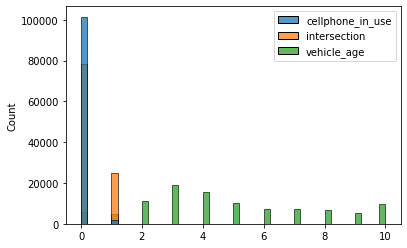

In [39]:
sns.histplot(features,bins=50)

четко видно,что в стобце испоьзовал ли телефон водитель сильно больше записей нежели в другиих слотбцах

<AxesSubplot:xlabel='at_fault', ylabel='Count'>

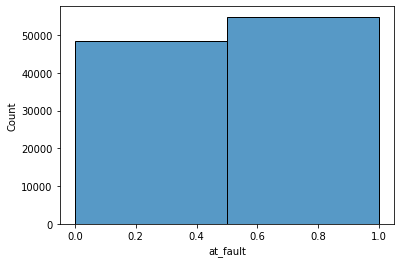

In [40]:
sns.histplot(target,bins=2)

дсибаланс классов присутствует,но он незначительный,можно ничего не делать с ним

In [41]:
features_train, features_test, target_train, target_test = train_test_split(features.copy(), target.copy(),
                                                                            test_size=.4, shuffle=True, 
                                                                            random_state=SEED)

features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train,
                                                                            test_size=.5, shuffle=True, 
                                                                            random_state=SEED)

display(features_train.shape, features_test.shape,features_valid.shape)
display(target_train.shape, target_test.shape,target_valid.shape)

(31033, 12)

(41378, 12)

(31034, 12)

(31033,)

(41378,)

(31034,)

In [42]:
features_train_valid = pd.concat([features_train.copy(), features_valid.copy()])
target_train_valid = pd.concat([target_train.copy(), target_valid.copy()])

In [43]:
# Создание трансформера для кодирования числовых признаков
numeric_features = ['cellphone_in_use','intersection','vehicle_age']

# Создание трансформера для кодирования категориальных признаков
categorical_features = ['party_sobriety', 'weather_1', 'road_surface', 'lighting', 'location_type', 'road_condition_1', 
              'vehicle_type', 'vehicle_transmission','control_device']

In [44]:
ct = ColumnTransformer(
                        [("text_preprocess", OneHotEncoder(handle_unknown='ignore',sparse=False), categorical_features),
                        ("num_preprocess", StandardScaler(),numeric_features )])

In [45]:
clf = SVC()
pipe = Pipeline([('transformer', ct), ('classifier', clf)])

In [46]:
%%time
model = pipe.fit(features_train_valid, target_train_valid)

CPU times: user 8min 22s, sys: 1.15 s, total: 8min 23s
Wall time: 8min 24s


In [47]:
%%time
model.score(features_test, target_test)

CPU times: user 4min 21s, sys: 540 ms, total: 4min 21s
Wall time: 4min 21s


0.581758422350041

In [48]:
%%time
scores = cross_val_score(model,features_train_valid, target_train_valid,cv = 3)

CPU times: user 12min 35s, sys: 1.68 s, total: 12min 37s
Wall time: 12min 37s


In [49]:
scores.mean()

0.583643482043598

In [50]:
%%time
pred=model.predict(features_test)

CPU times: user 3min 51s, sys: 396 ms, total: 3min 52s
Wall time: 3min 52s


<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:0px;
            border: 5px double;
            border-color:#9966FF;
            background-color: #FFFFCC;
            overflow:hidden;
            font-weight:400"> 
    
### создание и обучение моделей

<div style="padding: 10px 15px;
            border: 4px #6495ed solid;
            text-align:center>"
    
### RandomForestClassifier

In [51]:
# гиперпараметры модели
param_grid = {
    'classifier__criterion':['entropy'],
    'classifier__n_estimators': [10,50,100, 150],
    'classifier__max_depth': [2,5, 7,15],
    'classifier__min_samples_split': [2, 3,5],
    'classifier__class_weight':['balanced']
}

pipe_rf=Pipeline([('transformer', ct),
                  ('classifier', RandomForestClassifier())])

scorer = make_scorer(fbeta_score, beta=2)
# параметры RandomizedSearchCV
random_search_RF = RandomizedSearchCV(estimator=pipe_rf,
                                      param_distributions=param_grid,
                                      cv=5,
                                      verbose=2,
                                      random_state=SEED,
                                      scoring=scorer)

In [52]:
%%time
# обучение модели
random_search_RF.fit(features_train, target_train)
# сохраним лучшую модель
best_model_RF = random_search_RF.best_estimator_
# сохраним лучшее значение метрики
final_metrics_RF = random_search_RF.best_score_
# вывод результатов


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END classifier__class_weight=balanced, classifier__criterion=entropy, classifier__max_depth=5, classifier__min_samples_split=3, classifier__n_estimators=150; total time=   1.5s
[CV] END classifier__class_weight=balanced, classifier__criterion=entropy, classifier__max_depth=5, classifier__min_samples_split=3, classifier__n_estimators=150; total time=   1.4s
[CV] END classifier__class_weight=balanced, classifier__criterion=entropy, classifier__max_depth=5, classifier__min_samples_split=3, classifier__n_estimators=150; total time=   1.4s
[CV] END classifier__class_weight=balanced, classifier__criterion=entropy, classifier__max_depth=5, classifier__min_samples_split=3, classifier__n_estimators=150; total time=   1.5s
[CV] END classifier__class_weight=balanced, classifier__criterion=entropy, classifier__max_depth=5, classifier__min_samples_split=3, classifier__n_estimators=150; total time=   1.5s
[CV] END classifier__class_we

In [53]:
print(f'Оптимальные гиперпараметры:\n{random_search_RF.best_params_}\n F-beta: {final_metrics_RF}')

Оптимальные гиперпараметры:
{'classifier__n_estimators': 10, 'classifier__min_samples_split': 5, 'classifier__max_depth': 15, 'classifier__criterion': 'entropy', 'classifier__class_weight': 'balanced'}
 F-beta: 0.4259594735564717


In [54]:
# КОД РЕВЬЮЕРА
from sklearn.metrics import accuracy_score

accuracy_score(target_test, best_model_RF.predict(features_test))

0.5725989656339118

<div style="padding: 30px 25px; border: 2px #6495ed solid">

#### промежуточный вывод:
- Оптимальные гитерпараметры для алгоритма RandomForest:
    - 'n_estimators': 10
    - 'min_samples_split': 5
    - 'max_depth': 15
---
- Метрика качества F-beta на обучающих данных составляет: 0.43

    
</div>

<div style="padding: 10px 15px;
            border: 4px #6495ed solid;
            text-align:center>"
    
### Decision Tree Classifier

In [55]:

param_grid = {
   
    'classifier__max_depth': [2,5, 7,15],
    'classifier__min_samples_split': [2, 3,5],
    'classifier__class_weight':['balanced']
}

scorer = make_scorer(fbeta_score, beta=2)

pipe_dt=Pipeline([('transformer', ct),
          ('classifier', DecisionTreeClassifier())])


random_search_DT = RandomizedSearchCV(estimator=pipe_dt,
                                      param_distributions=param_grid,
                                      cv=5,
                                      verbose=2,
                                      random_state=SEED,
                                      scoring=scorer)

In [56]:
%%time
# обучение модели
random_search_DT.fit(features_train, target_train)
# сохраним лучшую модель
best_model_DT = random_search_DT.best_estimator_
# сохраним лучшее значение метрики
final_metrics_DT = random_search_DT.best_score_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END classifier__class_weight=balanced, classifier__max_depth=15, classifier__min_samples_split=3; total time=   0.3s
[CV] END classifier__class_weight=balanced, classifier__max_depth=15, classifier__min_samples_split=3; total time=   0.3s
[CV] END classifier__class_weight=balanced, classifier__max_depth=15, classifier__min_samples_split=3; total time=   0.3s
[CV] END classifier__class_weight=balanced, classifier__max_depth=15, classifier__min_samples_split=3; total time=   0.3s
[CV] END classifier__class_weight=balanced, classifier__max_depth=15, classifier__min_samples_split=3; total time=   0.3s
[CV] END classifier__class_weight=balanced, classifier__max_depth=15, classifier__min_samples_split=2; total time=   0.3s
[CV] END classifier__class_weight=balanced, classifier__max_depth=15, classifier__min_samples_split=2; total time=   0.3s
[CV] END classifier__class_weight=balanced, classifier__max_depth=15, classifier__min

In [57]:
print(f'Оптимальные гиперпараметры:\n{random_search_DT.best_params_}\n f-beta: {final_metrics_DT}')

Оптимальные гиперпараметры:
{'classifier__min_samples_split': 5, 'classifier__max_depth': 7, 'classifier__class_weight': 'balanced'}
 f-beta: 0.43082447420038517


<div style="padding: 30px 25px; border: 2px #6495ed solid">

#### промежуточный вывод:
- Оптимальные гитерпараметры для алгоритма Decision Tree:
    
    - 'min_samples_split': 7
    - 'max_depth': 7
---
- Метрика качества F-beta на обучающих данных составляет: 0.43
    
</div>

<div style="padding: 10px 15px;
            border: 4px #6495ed solid;
            text-align:center>"
    
### Catboost

In [58]:
grid = {
        'iterations': [100, 120],
        'learning_rate': [1,0.1,0.01,0.001, 0.005],
        'depth': [2,5,7,15]
       }
scorer = make_scorer(fbeta_score)
model_cat= CatBoostClassifier(loss_function='Logloss', eval_metric='F1')


In [59]:

# обучение модели
catboost_grid = RandomizedSearchCV(estimator=model_cat,
                                   param_distributions=grid,
                                      cv=5, 
                                  verbose=2,
                                  random_state=SEED,
                                  scoring=scorer)


In [60]:
%%time
catboost_grid.fit(features_train,target_train,cat_features=categorical_features)
# сохраним лучшую модель
best_model_CB = catboost_grid.best_estimator_
# сохраним лучшее значение метрики
final_metrics_CB = best_model_CB.best_score_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 0.3432017	total: 91.3ms	remaining: 10.9s
1:	learn: 0.5404827	total: 109ms	remaining: 6.45s
2:	learn: 0.5355162	total: 124ms	remaining: 4.84s
3:	learn: 0.5336173	total: 137ms	remaining: 3.97s
4:	learn: 0.5675561	total: 150ms	remaining: 3.44s
5:	learn: 0.5632667	total: 162ms	remaining: 3.08s
6:	learn: 0.5582944	total: 176ms	remaining: 2.84s
7:	learn: 0.5707039	total: 186ms	remaining: 2.6s
8:	learn: 0.5707647	total: 199ms	remaining: 2.46s
9:	learn: 0.5609241	total: 212ms	remaining: 2.33s
10:	learn: 0.5614761	total: 225ms	remaining: 2.23s
11:	learn: 0.5771115	total: 238ms	remaining: 2.14s
12:	learn: 0.5780538	total: 251ms	remaining: 2.07s
13:	learn: 0.5658615	total: 265ms	remaining: 2s
14:	learn: 0.5694603	total: 279ms	remaining: 1.95s
15:	learn: 0.5709709	total: 296ms	remaining: 1.92s
16:	learn: 0.5709585	total: 311ms	remaining: 1.89s
17:	learn: 0.5711275	total: 327ms	remaining: 1.85s
18:	learn: 0.5749069	total: 340ms	

In [61]:
print(f'Оптимальные гиперпараметры:\n{catboost_grid.best_params_}\n f-beta: {final_metrics_CB}')

Оптимальные гиперпараметры:
{'learning_rate': 1, 'iterations': 120, 'depth': 5}
 f-beta: {'learn': {'Logloss': 0.6321290270192292, 'F1': 0.589753016276194}}


In [62]:
pred_cat = best_model_CB.predict(features_valid)
print('F-beta на валидационной выборке:', fbeta_score(pred_cat, target_valid,beta=2))

F-beta на валидационной выборке: 0.603536612385067


<div style="padding: 30px 25px; border: 2px #6495ed solid">

#### промежуточный вывод:
- Оптимальные гитерпараметры для алгоритма catboost:
    - 'iterations': 100
    - 'learning_rate': 1
    - 'depth': 5
---
- Метрика качества f1 на обучающих данных составляет: 0.55

    
</div>

<div style="padding: 10px 15px;
            border: 4px #6495ed solid;
            text-align:center>"
    
### своя нейросеть

# Создадим тензоры
X_train = torch.Tensor(features_train_transformed)
X_test = torch.Tensor(features_test_transformed)

y_train = torch.FloatTensor(target_train.values)
y_test = torch.FloatTensor(target_test.values)

print('Кол-во строк и столбцов в X_train выборке:', X_train.shape)
print('Кол-во строк и столбцов в X_test выборке:', X_test.shape)

print('Кол-во строк и столбцов в y_train выборке:', y_train.shape)
print('Кол-во строк и столбцов в y_test выборке:', y_test.shape)

# параметры слоев сети
n_in_neurons = 47
n_hidden_neurons_1 = 24
n_hidden_neurons_2 = 12
n_out_neurons = 1

class Model(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Model, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.act3 = nn.ReLU()
        
        # Инициализация весов и смещений с помощью Xavier (Glorot initialization)
        init.xavier_uniform_(self.fc1.weight)
        init.constant_(self.fc1.bias, 0)  # Мы инициализируем смещения нулями
        init.xavier_uniform_(self.fc2.weight)
        init.constant_(self.fc2.bias, 0)
        init.xavier_uniform_(self.fc3.weight)
        init.constant_(self.fc3.bias, 0)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act1(x)
        x = self.fc3(x)
        x = self.act3(x)
        
        return x

# Укажем параметры сети
net = Model(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
loss =  nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
num_epochs = 200
batch_size = 20
num_batches = ceil(len(X_train)/batch_size)

from torch.utils.data import DataLoader, TensorDataset

# Создание DataLoader для тестовых данных
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


 %%time
# Найдем значение f1
df = {'epoch': [], 'f1': []}
total_step = len(X_train)

for epoch in range(num_epochs):
    net.train()
    order = np.random.permutation(len(X_train))
    
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(X_train))
        optimizer.zero_grad()
        
        batch_indexes = order[start_idx:end_idx]
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        y_batch = y_batch.view(-1,1)
        
        preds_train = net.forward(X_batch)
        loss_value_train = loss(preds_train, y_batch)
        loss_value_train.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0 or epoch == num_epochs:
        net.eval()
        true_labels = []
        predicted_labels = []
        
    with torch.no_grad():
        true_labels = []
        predicted_labels = []
    
        for X_test_batch, y_test_batch in test_dataloader:
            preds_test = net.forward(X_test_batch).argmax(dim=1).cpu().numpy()  # argmax для получения предсказанных классов
            true_labels.extend(y_test_batch.cpu().numpy())
            predicted_labels.extend(preds_test)
        
        f1 = f1_score(true_labels, predicted_labels)
        print('Эпоха [{}/{}], F1 Score: {:.4f}'.format(epoch+1, num_epochs, f1))
        df['epoch'].append(epoch+1)
        df['f1'].append(f1)

pivot = pd.DataFrame(data=df)
print(pivot.head())


fig, ax = plt.subplots(figsize=(5,5))

sns.lineplot(data = df, y='f1', x='epoch')

plt.title('зависимость f1 от эпохи')
plt.xlabel('эпохи')
plt.ylabel('f1')
plt.show()

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:0px;
            border: 5px double;
            border-color:#9966FF;
            background-color: #FFFFCC;
            overflow:hidden;
            font-weight:400"> 
    
### выбор и тестирование финальной модели

In [63]:
predictive_model_scores = pd.DataFrame(data= [('SVC',fbeta_score
                                              (pred,target_test,beta=2)),
                                              
                                              ('Decision Tree',fbeta_score
                                              (best_model_DT.predict(features_test),target_test,beta=2)), 
                                             
                                             ('Random Forest',fbeta_score
                                              (best_model_RF.predict(features_test),target_test,beta=2)),
                                             
                                            ('CatBoost',fbeta_score
                                             (best_model_CB.predict(features_test),target_test,beta=2))], 
                                       columns=['model', 'training_f-beta'])
predictive_model_scores

,model,training_f-beta
0,SVC,0.596507
1,Decision Tree,0.592500
2,Random Forest,0.579958
3,CatBoost,0.598273


In [64]:
predicted_test_cb = best_model_CB.predict(features_test)

In [76]:
predct_proba_test_cb=best_model_CB.predict_proba(features_test)

In [79]:
predct_proba_test_cb= predct_proba_test_cb[:, 1]

In [65]:
cm_cb = confusion_matrix(target_test, predicted_test_cb)

In [66]:
cm_df_cb = pd.DataFrame(cm_cb, index=['Actually Not At Fault', 'Actually At Fault'],
                 columns=['Predicted Not At Fault', 'Predicted At Fault'])

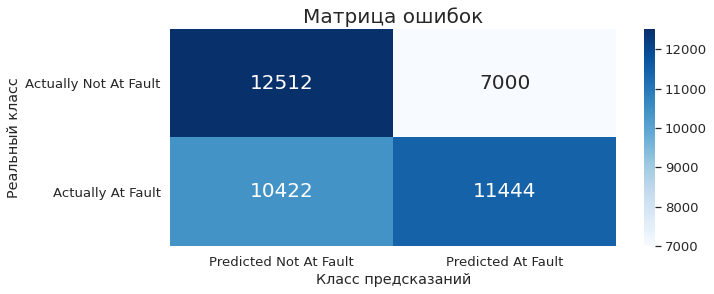

In [68]:
sns.set(font_scale=1.2)
plt.figure(figsize=(10,4))
    
sns.heatmap(cm_cb, annot=True, fmt='g', cmap="Blues",xticklabels=cm_df_cb.columns, yticklabels=cm_df_cb.index, annot_kws={"size": 20})
plt.title("Матрица ошибок", size=20)
plt.xlabel('Класс предсказаний')
plt.ylabel('Реальный класс');

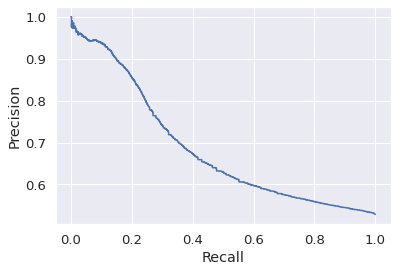

In [80]:
prec, recall, _ = precision_recall_curve(target_test,predct_proba_test_cb)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

In [ ]:
TP = cm_cb[0][0]
TN = cm_cb[1][1]
FP = cm_cb[0][1]
FN = cm_cb[1][0]
total = cm_cb[0][0]+cm_cb[1][1]+cm_cb[0][1]+cm_cb[1][0]

print('Всего предсказаний:',total)
print(f'Правильно классифицированные: {np.round((TP+TN)/total*100)}%')
print(f'Правильно классифицированная вина: {np.round(TP/(TP+FN)*100)}%')
print(f'Правильно классифицированое отсутствие вины: {np.round(TN/(TN+FP)*100)}%')
print(f'Прогнозируемая вина, соответствующая действительности: {np.round(TP/(TP+FP)*100)}%')
print(f'Прогнозируемое отсутствие вины, которой так же на самом деле нет: {np.round(TN/(TN+FN)*100)}%')

<div style="padding: 30px 25px; border: 5px #9966FF solid">
    
### вывод по главе 'модель для оценки водительского риска':
    
- создали и протестировали 4 модели
- построили матрицу ошибок лучшей модели
- сделали выводы на основе этой матрицы
    
---
- лучшей моделью для финального тестирования окалазась модель Catboost

## Проведите анализ важности факторов ДТП

In [ ]:
feat_importances_dt = pd.Series((best_model_CB.feature_importances_), index=features.columns)
feat_importances_dt.nlargest(5).plot(kind='barh')
plt.show()

In [ ]:
pred=best_model_CB.predict(features_test)

In [ ]:
importances = best_model_CB.feature_importances_

In [ ]:
feature_list = list(features_train.columns)

In [ ]:
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})

In [ ]:
feature_results.head()

In [ ]:
indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(15, 6))
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(features_train.columns)[indices])

In [ ]:
group_vehicle_age = df[df['at_fault'] == 1].groupby('vehicle_age')['at_fault'].count().plot(kind='bar', figsize=(15, 6))

In [ ]:
y_vehicle_age = df[df['at_fault'] == 0].groupby('vehicle_age')['at_fault'].count().plot(kind='bar', figsize=(15, 6))

In [ ]:
group_party_sobriety = df[df['at_fault'] == 1].groupby('party_sobriety')['at_fault'].count().plot(kind='bar', figsize=(15, 6))

In [ ]:
y_sobriety = df[df['at_fault'] == 0].groupby('party_sobriety')['at_fault'].count().plot(kind='bar', figsize=(15, 6))

## Выводы


<div  style="padding: 30px 25px; border: 5px #9966FF solid">
    
# вывод
- выявили, что самый важный фактор ДТП — уровень трезвости виновника party_sobriety. Из таблицы исходных данных известно, что     есть несколько уровней трезвости. Благодоря столбчатой диаграмм, которая отражает зависимость числа ДТП от уровня трезвости, можно сделать вывод, что в основном ДТП происходят, когда участник трезв, но вероятность виновности в ДТП выше, когда участник пьян. Для решения проблемы необходимо оборудовать автомобиль анализатором алкогольного опьянения. Измерение состояния при посадке сделать обязательным условием допуска за руль. А чтобы убедиться, что в трубку дышит именно водитель, добавить камеру с машинным зрением, направленную на водительское место.
--- 
модель с лучшеми параметрми это catboost :
- 'depth': 7,
- 'iterations': 100,
- 'learning_rate': 0.001
</div> 